# Calculate Simplified Ikeda and insert into DB

In [6]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from rolldecay.simplified_ikeda import calculate_roll_damping

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian

In [4]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [5]:
sql="""
SELECT * from
rolldecay_linear
INNER JOIN run
ON rolldecay_linear.run_id == run.id
    INNER JOIN loading_conditions
    ON run.loading_condition_name == loading_conditions.name
        INNER JOIN models
        ON run.model_number == models.model_number
            INNER JOIN ships
            ON models.ship_name == ships.name

"""
df_rolldecay = pd.read_sql(sql, con=engine, index_col='run_id',)

In [13]:
def calculate(row, PHI):
    
    LPP = row.lpp
    Beam = row.beam
    DRAFT = (row.TA + row.TF)/2
    
    lBK = row.BKL
    bBK = row.BKB
    OMEGA = row.omega0
    OG = row.kg
    CB = row.Volume/(row.lpp*row.beam*DRAFT)
    CMID = row.A0
    
    B44HAT, BFHAT, BWHAT, BEHAT, BBKHAT = calculate_roll_damping(LPP,Beam,CB,CMID,OG,PHI,lBK,bBK,OMEGA,DRAFT)
    s = pd.Series()
    s['B44HAT'] = B44HAT
    s['BFHAT'] = BFHAT
    s['BWHAT'] = BWHAT
    s['BEHAT'] = BEHAT
    s['BBKHAT'] = BBKHAT
    return s
    

In [21]:
mask = ((df_rolldecay['lpp'] > 0) &
        (df_rolldecay['beam'] > 0) &
        (df_rolldecay['TA'] > 0) &
        (df_rolldecay['Volume'] > 0)
       )
df = df_rolldecay.loc[mask].copy()

In [22]:
result = df.apply(func=calculate, PHI=10, axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15411150>]],
      dtype=object)

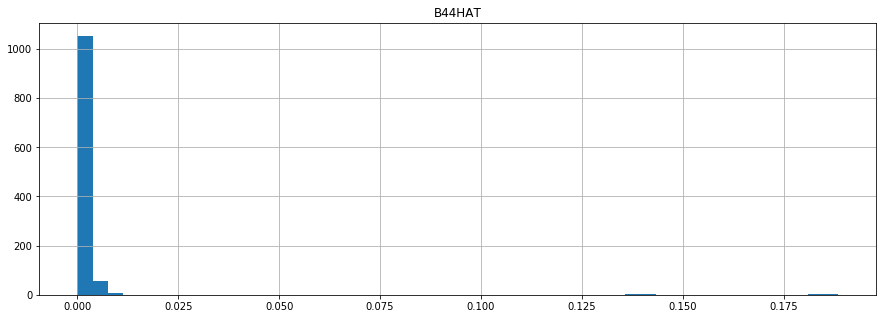

In [26]:
mask = result['B44HAT'] > 0
df = result.loc[mask]
df.hist('B44HAT', bins=50)